# 프로젝트. 뉴스 카테고리 다중분류
## Vocabulary Size 변경해서 시도해보기

### 들어가며

- 로이터(reuters) 뉴스 데이터
    - 케라스에서 제공
    - 총 11,258개 뉴스 기사
    - 총 46개 뉴스 카테고리로 분류
    
- 로이터(reuters) 뉴스 텍스트 데이터를 Bag of Words 가설을 기반으로 하는
- __DTM__, __TF-IDF__ 벡터화 전처리를 하고, **Machine Learning 모델**로 학습시킨다.


- Machine Learning Model 학습
    - 나이브 베이즈 분류기
    - CNB
    - 로지스틱 회귀
    - 서포트 벡터 머신(SVM)
    - 결정 트리
    - 랜덤 포레스트
    - 그래디언트 부스팅 트리
    - 보팅
    

- 데이터의 전처리
    - Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수는 성능에 큰 영향을 줄 수 있다. 
    - 중요도가 낮은 단어들을 포함해 너무 많은 단어나, 너무 적은 단어들을 사용하게 되면 성능 저하가 될 수 있으며,
    - 이렇게 변화된 단어의 수는 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있다. 
    - 따라서 __단어의 수(Vocab size)__에 따라서 __머신러닝모델의 성능__이 어떻게 변하는지 테스트한다.


- 사용할 단어 수

    1. 모든 단어 사용
    
    2. 빈도수 상위 5,000개 사용
    
    3. 직접 단어 개수 설정(전체 단어수 : 30979개)
        - 약 20% :  6000개
        - 약 30% :  9000개
        - 약 40% : 12000개
        - 약 50% : 15000개


### Package load

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# vectorize module
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## 1. 모든 단어 사용

### 데이터 로드

In [3]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


In [4]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

# 데이터 출력
print("\n데이터 출력")
print(x_train[0])
print(x_test[0])

num_classes = max(y_train) + 1

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246

데이터 출력
[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47,

### 데이터 복원

In [5]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
# {'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, ...}

index_to_word = {index + 3 : word for word, index in word_index.items()}
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# train 데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
x_train = decoded

# test 데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)
x_test = decoded

# 데이터 확인
print(x_train[0])
print(x_test[0])

565248/550378 [==============================] - 0s 0us/step
<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 

### 벡터화

In [6]:
dtmvector = CountVectorizer()  # DTM 생성
tfidf_transformer = TfidfTransformer()  # TF-IDF 생성

# train data
x_train_dtm = dtmvector.fit_transform(x_train)
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(x_train_dtm.shape)
print(tfidfv.shape)

# test data
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

(8982, 26506)
(8982, 26506)


## 머신러닝 모델 학습

### 나이브 베이즈 분류기

In [7]:
mod = MultinomialNB()
mod.fit(tfidfv, y_train)    # 모델 학습

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted),'\n') #예측값과 실제
# print(classification_report(y_test, mod.predict(tfidfv_test)))

정확도: 0.5997328584149599 



In [8]:
# confusion matrix 시각화
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

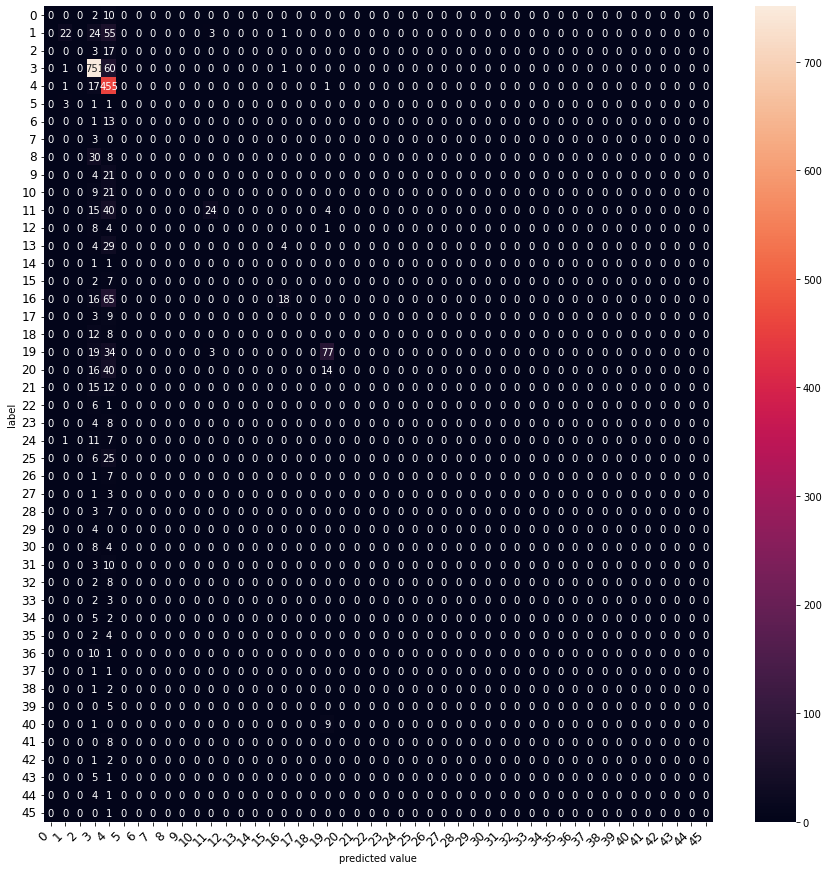

In [9]:
graph_confusion_matrix(mod, tfidfv_test, y_test)

### CNB

In [10]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7649154051647373


### 로지스틱 회귀

In [11]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.813446126447017


### 서포트 벡터 머신(SVM)

In [12]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7778272484416741


### 결정 트리(Decision Tree)

In [13]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6211041852181657


### 랜덤 포레스트(Random Forest)

In [14]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6544968833481746


### 그래디언트 부스팅 트리(Gradient Boosting Classifier)

In [15]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7702582368655387


### 보팅(Voting)

In [16]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8187889581478184


## 2. 빈도수 상위 5,000개 단어 사용

### 데이터 로드

In [21]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [22]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

# 데이터 출력
print("\n데이터 출력")
print(x_train[0])
print(x_test[0])

num_classes = max(y_train) + 1

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246

데이터 출력
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 1

### 데이터 복원

In [23]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
# {'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, ...}

index_to_word = {index + 3 : word for word, index in word_index.items()}
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# train 데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
x_train = decoded

# test 데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)
x_test = decoded

# 데이터 확인
print(x_train[0])
print(x_test[0])

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program b

### 벡터화

In [24]:
dtmvector = CountVectorizer()  # DTM 생성
tfidf_transformer = TfidfTransformer()  # TF-IDF 생성

# train data
x_train_dtm = dtmvector.fit_transform(x_train)
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(x_train_dtm.shape)
print(tfidfv.shape)

# test data
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

(8982, 4867)
(8982, 4867)


## 머신러닝 모델 학습

### 나이브 베이즈 분류기

In [25]:
mod = MultinomialNB()
mod.fit(tfidfv, y_train)    # 모델 학습

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted),'\n') #예측값과 실제
# print(classification_report(y_test, mod.predict(tfidfv_test)))

정확도: 0.6731967943009796 



In [26]:
# confusion matrix 시각화
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

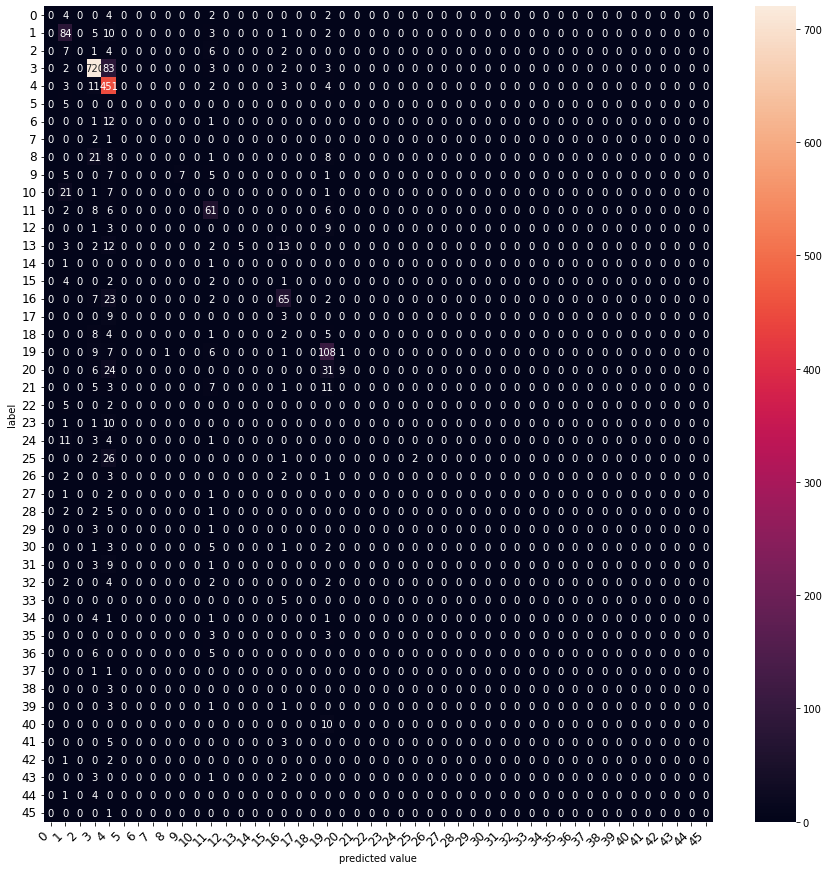

In [27]:
graph_confusion_matrix(mod, tfidfv_test, y_test)

### CNB

In [28]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


### 로지스틱 회귀

In [29]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8058771148708815


### 서포트 벡터 머신(SVM)

In [30]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7680320569902048


### 결정 트리(Decision Tree)

In [31]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6179875333926982


### 랜덤 포레스트(Random Forest)

In [32]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.701246660730187


### 그래디언트 부스팅 트리(Gradient Boosting Classifier)

In [33]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.767586821015138


### 보팅(Voting)

In [34]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8161175422974176


## 3. 직업 단어 갯수 설정 - 빈도수 상위 9,000개 단어 사용

### 데이터 로드

In [39]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=9000, test_split=0.2)

In [40]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

# 데이터 출력
print("\n데이터 출력")
print(x_train[0])
print(x_test[0])

num_classes = max(y_train) + 1

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246

데이터 출력
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 1

### 데이터 복원

In [41]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
# {'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, ...}

index_to_word = {index + 3 : word for word, index in word_index.items()}
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# train 데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
x_train = decoded

# test 데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)
x_test = decoded

# 데이터 확인
print(x_train[0])
print(x_test[0])

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program b

### 벡터화

In [42]:
dtmvector = CountVectorizer()  # DTM 생성
tfidf_transformer = TfidfTransformer()  # TF-IDF 생성

# train data
x_train_dtm = dtmvector.fit_transform(x_train)
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(x_train_dtm.shape)
print(tfidfv.shape)

# test data
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

(8982, 8721)
(8982, 8721)


## 머신러닝 모델 학습

### 나이브 베이즈 분류기

In [43]:
mod = MultinomialNB()
mod.fit(tfidfv, y_train)    # 모델 학습

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted),'\n') #예측값과 실제
# print(classification_report(y_test, mod.predict(tfidfv_test)))

정확도: 0.6589492430988424 



In [44]:
# confusion matrix 시각화
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

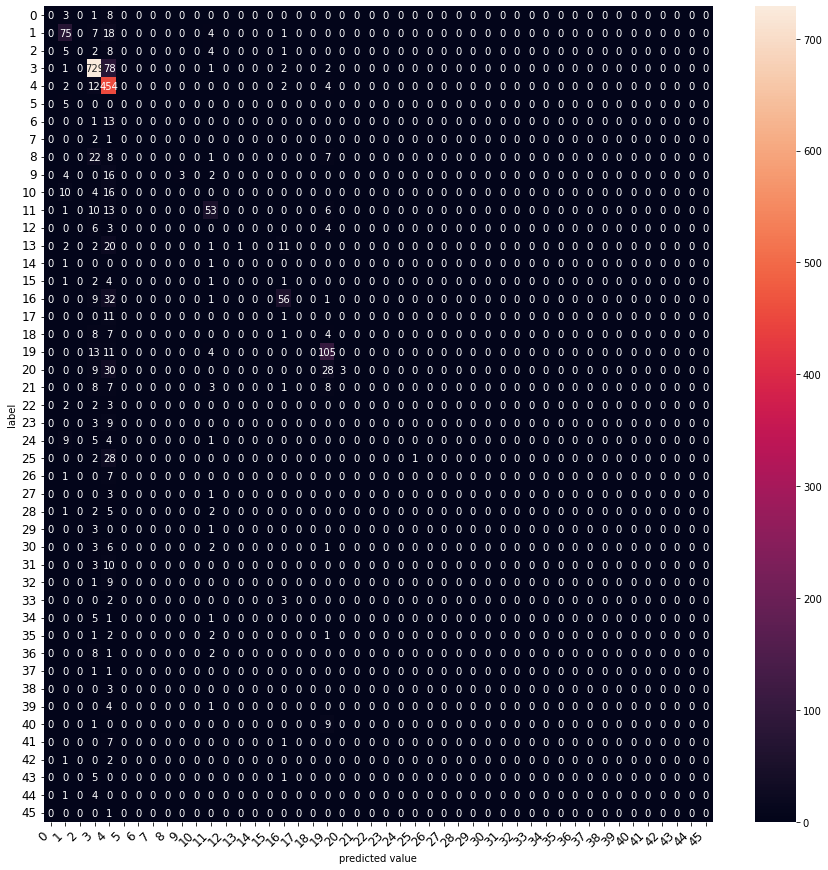

In [45]:
graph_confusion_matrix(mod, tfidfv_test, y_test)

### CNB

In [46]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7715939447907391


### 로지스틱 회귀

In [47]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8103294746215495


### 서포트 벡터 머신(SVM)

In [48]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7773820124666073


### 결정 트리(Decision Tree)

In [49]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6184327693677649


### 랜덤 포레스트(Random Forest)

In [50]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6874443455031166


### 그래디언트 부스팅 트리(Gradient Boosting Classifier)

In [51]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7684772929652716


### 보팅(Voting)

In [52]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8130008904719501


## 4. 직업 단어 갯수 설정 - 빈도수 상위 12,000개 단어 사용

### 데이터 로드

In [57]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=12000, test_split=0.2)

In [58]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

# 데이터 출력
print("\n데이터 출력")
print(x_train[0])
print(x_test[0])

num_classes = max(y_train) + 1

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246

데이터 출력
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 1

### 데이터 복원

In [59]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
# {'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, ...}

index_to_word = {index + 3 : word for word, index in word_index.items()}
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# train 데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
x_train = decoded

# test 데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)
x_test = decoded

# 데이터 확인
print(x_train[0])
print(x_test[0])

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program b

### 벡터화

In [60]:
dtmvector = CountVectorizer()  # DTM 생성
tfidf_transformer = TfidfTransformer()  # TF-IDF 생성

# train data
x_train_dtm = dtmvector.fit_transform(x_train)
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(x_train_dtm.shape)
print(tfidfv.shape)

# test data
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

(8982, 11540)
(8982, 11540)


## 머신러닝 모델 학습

### 나이브 베이즈 분류기

In [61]:
mod = MultinomialNB()
mod.fit(tfidfv, y_train)    # 모델 학습

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted),'\n') #예측값과 실제
# print(classification_report(y_test, mod.predict(tfidfv_test)))

정확도: 0.6482635796972396 



In [62]:
# confusion matrix 시각화
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

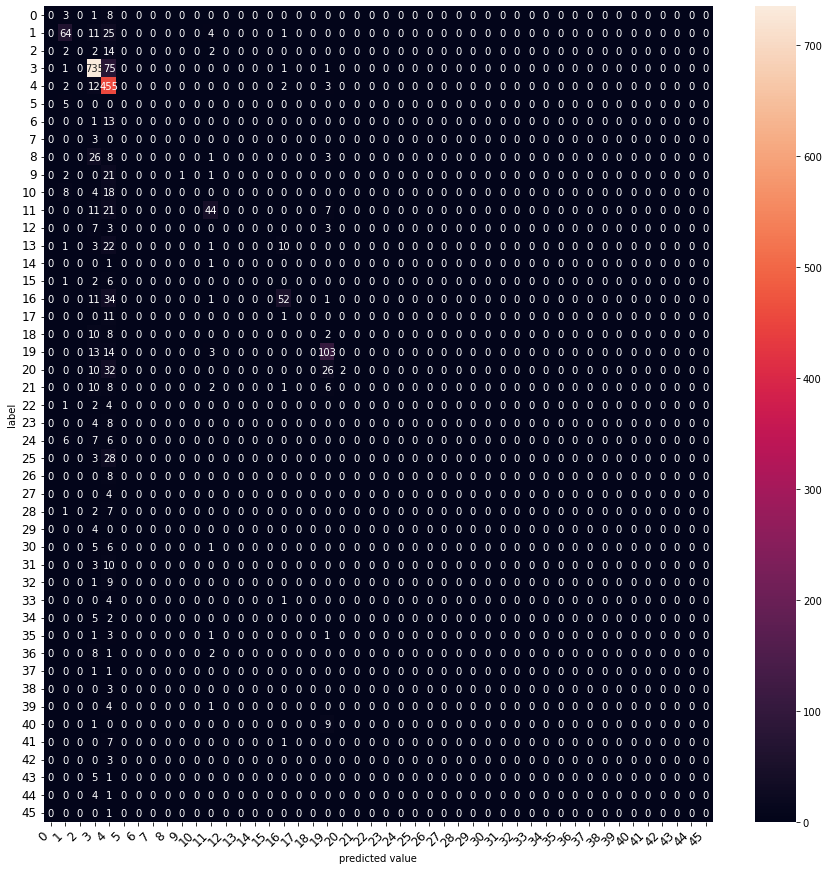

In [63]:
graph_confusion_matrix(mod, tfidfv_test, y_test)

### CNB

In [64]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7742653606411398


### 로지스틱 회귀

In [65]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8116651825467498


### 서포트 벡터 머신(SVM)

In [66]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7831700801424755


### 결정 트리(Decision Tree)

In [67]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6166518254674977


### 랜덤 포레스트(Random Forest)

In [68]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6825467497773821


### 그래디언트 부스팅 트리(Gradient Boosting Classifier)

In [69]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7680320569902048


### 보팅(Voting)

In [70]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8178984861976848


## 5. 직업 단어 갯수 설정 - 빈도수 상위 15,000개 단어 사용

### 데이터 로드

In [75]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2)

In [76]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

# 데이터 출력
print("\n데이터 출력")
print(x_train[0])
print(x_test[0])

num_classes = max(y_train) + 1

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246

데이터 출력
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 1

### 데이터 복원

In [77]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
# {'mdbl': 10996, 'fawc': 16260, 'degussa': 12089, ...}

index_to_word = {index + 3 : word for word, index in word_index.items()}
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# train 데이터 복원
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
x_train = decoded

# test 데이터 복원
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)
x_test = decoded

# 데이터 확인
print(x_train[0])
print(x_test[0])

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program b

### 벡터화

In [78]:
dtmvector = CountVectorizer()  # DTM 생성
tfidf_transformer = TfidfTransformer()  # TF-IDF 생성

# train data
x_train_dtm = dtmvector.fit_transform(x_train)
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(x_train_dtm.shape)
print(tfidfv.shape)

# test data
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

(8982, 14227)
(8982, 14227)


## 머신러닝 모델 학습

### 나이브 베이즈 분류기

In [79]:
mod = MultinomialNB()
mod.fit(tfidfv, y_train)    # 모델 학습

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted),'\n') #예측값과 실제
# print(classification_report(y_test, mod.predict(tfidfv_test)))

정확도: 0.6331255565449688 



In [80]:
# confusion matrix 시각화
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

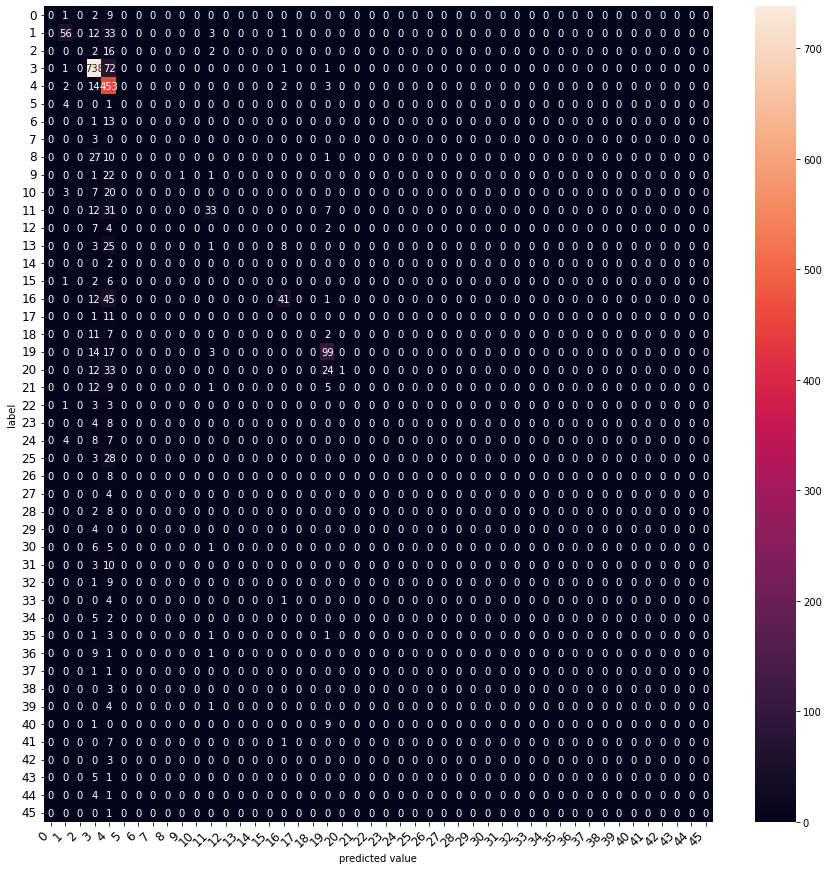

In [81]:
graph_confusion_matrix(mod, tfidfv_test, y_test)

### CNB

In [82]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7720391807658059


### 로지스틱 회귀

In [83]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8125556544968834


### 서포트 벡터 머신(SVM)

In [84]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7796081923419412


### 결정 트리(Decision Tree)

In [85]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6193232413178985


### 랜덤 포레스트(Random Forest)

In [86]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6714158504007124


### 그래디언트 부스팅 트리(Gradient Boosting Classifier)

In [87]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


### 보팅(Voting)

In [88]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8165627782724845


### RNN

In [89]:
(rnn_x_train, rnn_y_train), (rnn_x_test, rnn_y_test) = reuters.load_data(num_words=None, test_split=0.2)
print(len(rnn_x_train), len(rnn_x_test))
max_len = max(len(l) for l in np.concatenate((rnn_x_train, rnn_x_test), axis=0))
print('max_len : ', max_len)

8982 2246
max_len :  2376


In [90]:
rnn_x_train = pad_sequences(rnn_x_train, maxlen=max_len)
rnn_x_test = pad_sequences(rnn_x_test, maxlen=max_len)

rnn_y_train = to_categorical(rnn_y_train, num_classes=46)
rnn_y_test = to_categorical(rnn_y_test, num_classes=46)

rnn_x_train = rnn_x_train[1000:]
rnn_y_train = rnn_y_train[1000:]
rnn_x_val = rnn_x_train[:1000]
rnn_y_val = rnn_y_train[:1000]

In [91]:
vocab_size = len(index_to_word)
print(vocab_size)
word_vector_dim = 120

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model.add(keras.layers.LSTM(120))
model.add(keras.layers.Dense(46, activation='softmax'))
# 모델 훈련
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(rnn_x_train, rnn_y_train, epochs=30, callbacks=[es], batch_size=128, validation_data=(rnn_x_val, rnn_y_val), verbose=1)

30982
Epoch 1/30
63/63 [==============================] - 14s 191ms/step - loss: 0.2158 - accuracy: 0.2211 - val_loss: 0.0741 - val_accuracy: 0.3260
Epoch 2/30
63/63 [==============================] - 12s 183ms/step - loss: 0.0724 - accuracy: 0.3514 - val_loss: 0.0732 - val_accuracy: 0.3260
Epoch 3/30
63/63 [==============================] - 12s 183ms/step - loss: 0.0720 - accuracy: 0.3514 - val_loss: 0.0731 - val_accuracy: 0.3260
Epoch 4/30
63/63 [==============================] - 12s 183ms/step - loss: 0.0719 - accuracy: 0.3514 - val_loss: 0.0730 - val_accuracy: 0.3260
Epoch 5/30
63/63 [==============================] - 11s 182ms/step - loss: 0.0720 - accuracy: 0.3450 - val_loss: 0.0731 - val_accuracy: 0.3260
Epoch 6/30
63/63 [==============================] - 12s 183ms/step - loss: 0.0719 - accuracy: 0.3514 - val_loss: 0.0731 - val_accuracy: 0.3260
Epoch 7/30
63/63 [==============================] - 12s 183ms/step - loss: 0.0719 - accuracy: 0.3514 - val_loss: 0.0731 - val_accuracy: 

In [92]:
model.evaluate(rnn_x_test, rnn_y_test)

71/71 [==============================] - 3s 42ms/step - loss: 0.0720 - accuracy: 0.3620


[0.07203298062086105, 0.36197686195373535]

### 각 모델 성능 현황

|model|total|5,000|9,000|12,000|15,000|
|:-|:-|:-|:-|:-|:-|
|나이브 베이즈 분류기|0.59|0.67|0.65|0.64|0.63|
|CNB|0.76|0.77|0.77|0.77|0.77|
|로지스틱 회귀|0.81|0.80|0.81|0.81|0.81|
|서포트 벡터 머신|0.77|0.76|0.77|0.78|0.77|
|결정 트리|0.62|0.61|0.61|0.61|0.61|
|랜덤 포레스트|0.65|0.70|0.68|0.68|0.67|
|그래디언트 부스팅 트리|0.77|0.76|0.76|0.76|0.77|
|보팅|0.81|0.81|0.81|0.81|0.81|
|RNN|    |    |    |    |0.36|



## 회고

- 빈도수 상위 n개 단어 갯수에 따라 각 머신러닝 모델별 차이를 보일 줄 알았으나 위 현황에서 보시다시피 큰 차이가 없었다.
- 데이터의 특성과 전처리 방법에 따라 적절한 모델로 학습하는 것이 필요하고 그것을 판단할 수 있어야겠다고 느끼게 되었다.
- 머신러닝 모델 중 80% 이상의 성능을 보여준 `보팅`, `로지스틱 회귀` 모델이 가장 우수했다.
- 여러 모델의 결과를 활용하는 앙상블 기법이 우수한 성능을 보여준것 같다.